In [13]:
import pytorch_lightning as pl
import pytorch_lightning.callbacks as pl_callbacks
import torch
import eq

## Loading the catalog

By default, all catalogs are saved to the following directory

In [14]:
print(eq.data.default_catalogs_dir)

/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/data


We load the catalog constructed by White et al. The catalog records earthquakes between `2008-01-01` and `2021-01-01`.
The following code automatically downloads and preprocesses the catalog, or loads it from the data directory, if it's already there.

In [15]:
catalog = eq.catalogs.White()

Generating the catalog...
Downloading...


AttributeError: 'dict' object has no attribute 'mag_completeness'

Other available catalogs:
- `eq.catalogs.SCEDC`
- `eq.catalogs.QTMSanJacinto`
- `eq.catalogs.QTMSaltonSea`

### Representing the data
We can represent all data stored in the catalog as an object of type `eq.data.Sequence`.

In [ ]:
catalog.full_sequence

Sequence(
  inter_times: [134976],
  arrival_times: [134975],
  t_start: 0.0,
  t_end: 4749.0,
  t_nll_start: 0.0,
  mag: [134975]
)

An `eq.data.Sequence` object contains the following attributes:
- `t_start` and `t_end`: Start and end of the time interval containing the events (in days).
- `arrival_times`: Arrival times of each event (in days), shape `[num_events]`
- `inter_times`: Inter-event times, shape `[num_events + 1]` since this also includes the last survival time from `arrival_times[-1]` until `t_end`.
- `mag`: Magnitude of each earthquake, shape `[num_events]`.
- `t_nll_start`: This attributed allows to compute the negative log-likelihood (NLL) only for the observations in the interval `[t_nll_start, t_end]`, while conditioning the model on past events in `[t_start, t_nll_start]`.

<Axes: xlabel='Time (days)', ylabel='Magnitude'>

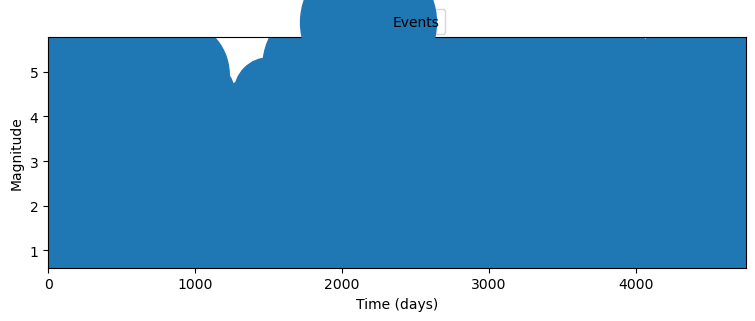

In [5]:
eq.visualization.visualize_sequence(catalog.full_sequence)

### Train / val / test split

To compare different models, we split the full event sequence into 3 components:
- `train`: used for training the models, includes events between `2008-01-01` and `2014-01-01`.
- `val`: used for early stopping and hyperparameter selection, includes events between `2014-01-01` and `2017-01-01`.
- `test`: used for final evaluation, includes events between `2017-01-01` and `2021-01-01`.

We already provided the start of the val and test intervals when loading the catalog, so now the train, val and test sequences are stored in `catalog.train`, `catalog.val` and `catalog.test`, respectively.

In our case the catalog consists of a single event sequence but, in principle, there could be multiple event sequences stored in `catalog.train`, `catalog.val` and `catalog.test`.

In [6]:
print("Train sequence:")
print(catalog.train[0])
print("\nValidation sequence:")
print(catalog.val[0])
print("\nTest sequence:")
print(catalog.test[0])

Train sequence:
Sequence(
  inter_times: [52613],
  arrival_times: [52612],
  t_start: 0.0,
  t_end: 2192.0,
  t_nll_start: 366.0,
  mag: [52612]
)

Validation sequence:
Sequence(
  inter_times: [85663],
  arrival_times: [85662],
  t_start: 0.0,
  t_end: 3288.0,
  t_nll_start: 2192.0,
  mag: [85662]
)

Test sequence:
Sequence(
  inter_times: [134976],
  arrival_times: [134975],
  t_start: 0.0,
  t_end: 4749.0,
  t_nll_start: 3288.0,
  mag: [134975]
)


Note that, for example, the `test` sequence contains all events in the catalog, including the training set.

However, since we specified `t_nll_start`, the model will know to only compute the NLL on the interval `[t_nll_start, t_end]` (shown in orange in the figure below), while also conditioning on the events from `[0, t_nll_start]`.

<Axes: xlabel='Time (days)', ylabel='Magnitude'>

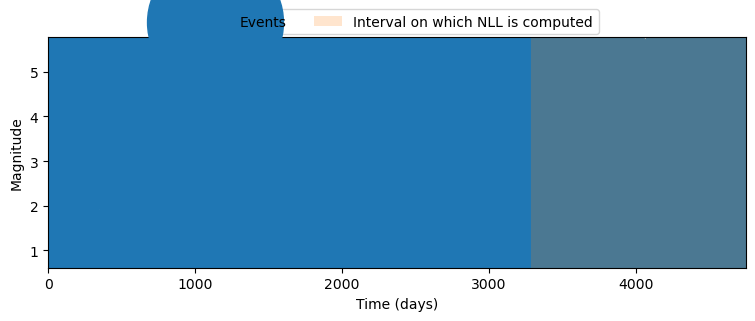

In [7]:
eq.visualization.visualize_sequence(catalog.test[0], show_nll=True)

## Training the model

We will train the model using the high-level API provided by `pytorch_lightning`.

For this, we first need to create `torch.utils.data.DataLoader` objects that will feed the data into the model.

In [8]:
dl_train = catalog.train.get_dataloader()
dl_val = catalog.val.get_dataloader()
dl_test = catalog.test.get_dataloader()

Now, we initialize the model.

In [9]:
model = eq.models.RecurrentTPP()

`pytorch_lightning.Trainer` takes care of training the model, early stopping and saving the best weights.

In this toy example, we set `max_epochs=200` and `patience=20` to get to the results more quickly.

In the experiments in the paper, we trained the models for longer with `max_epochs=1500` and `patience=200`.

In [11]:
# ModelCheckpoints saves the model with the best validation loss
checkpoint = pl_callbacks.ModelCheckpoint(monitor="val_loss")

# EarlyStopping stops training if the validation loss doesn't improve by more than 1e-3 for 20 epochs
early_stopping = pl_callbacks.EarlyStopping(monitor="val_loss", patience=20, min_delta=1e-3)

num_gpus = int(torch.cuda.is_available())  # equals to 1 if GPU is available, 0 otherwise
trainer = pl.Trainer(max_epochs=200, callbacks=[checkpoint, early_stopping])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [12]:
trainer.fit(model, dl_train, dl_val)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/3
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/3
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/3
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 3 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type    | Params
------------------------------------------
0 | hypernet_time | Linear  | 3.2 K 
1 | hypernet_mag  | Linear  | 33    
2 | rnn           | GRU     | 3.5 K 
3 | dropout       | Dropout | 0     
------------------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


ProcessRaisedException: 

-- Process 2 terminated with the following error:
Traceback (most recent call last):
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/torch/multiprocessing/spawn.py", line 69, in _wrap
    fn(i, *args)
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 153, in _wrapping_function
    results = function(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py", line 571, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py", line 980, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py", line 1021, in _run_stage
    self._run_sanity_check()
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py", line 1050, in _run_sanity_check
    val_loop.run()
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py", line 181, in _decorator
    return loop_run(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/loops/evaluation_loop.py", line 115, in run
    self._evaluation_step(batch, batch_idx, dataloader_idx)
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/loops/evaluation_loop.py", line 376, in _evaluation_step
    output = call._call_strategy_hook(trainer, hook_name, *step_kwargs.values())
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py", line 294, in _call_strategy_hook
    output = fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/strategies/ddp.py", line 338, in validation_step
    return self.model(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/torch/nn/parallel/distributed.py", line 1156, in forward
    output = self._run_ddp_forward(*inputs, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/torch/nn/parallel/distributed.py", line 1110, in _run_ddp_forward
    return module_to_run(*inputs[0], **kwargs[0])  # type: ignore[index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/yes/envs/DS-discovery/lib/python3.11/site-packages/pytorch_lightning/overrides/base.py", line 102, in forward
    return self._forward_module.validation_step(*inputs, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/eq/models/tpp_model.py", line 89, in validation_step
    total_loss = self.step(batch, "val", no_grad=True)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/eq/models/tpp_model.py", line 98, in step
    loss = self.nll_loss(batch)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/eq/models/recurrent.py", line 161, in nll_loss
    context = self.get_context(batch)  # (B, L, C)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/eq/models/recurrent.py", line 115, in get_context
    feat_list.append(self.encode_magnitude(batch.mag, batch.mag_bounds[:,0]))
                                                      ^^^^^^^^^^^^^^^^
  File "/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/eq/data/dot_dict.py", line 59, in __getattr__
    raise AttributeError(
AttributeError: 'Batch' has no attribute 'mag_bounds'


## Evaluation

Load the model with the best validation loss

In [ ]:
model.load_from_checkpoint(checkpoint.best_model_path)

RecurrentTPP(
  (hypernet_time): Linear(in_features=32, out_features=96, bias=True)
  (hypernet_mag): Linear(in_features=32, out_features=1, bias=True)
  (rnn): GRU(2, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

After training the model, we compute the loss on the negative log-likelihood (NLL) loss on the test set.

In [ ]:
trainer.test(model, dl_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
/nfs/staff-ssd/shchur/miniconda3/envs/eq/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': -88.63616943359375}
--------------------------------------------------------------------------------


[{'test_loss': -88.63616943359375}]